Importação das funções auxiliares e bibliotecas de aprendizado de máquina utilizados.

In [97]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier



from copy import deepcopy
from itertools import count
import random
from matplotlib.pyplot import axis
from sklearn.utils import shuffle
from math import ceil
import pandas as pd

def printa(a):
    print(a)
    return

def normalizaMinMax(coluna):
    minimo = coluna.min()
    maximo = coluna.max()
    return (coluna-minimo)/(maximo-minimo)

def split_in_folds(data, k):
    max_fold_size = ceil(data["id"].count()/k)
    folds = []
    for fold_index in range(k):
        folds.append([])
        for item_index in range(max_fold_size):
            item = data.sample()
            data.drop(item.index, inplace=True)
            folds[fold_index].append(item)
            if data.empty:
                break
    return folds

def merge_folds(folds):
    result = []
    for fold in folds:
        result += fold
    return result

def fold_to_df(fold):
    df = fold[0]
    for item_index in range(1, len(fold)):
        df = pd.concat([df, fold[item_index]])
    return df

def k_fold(data, k=5):
    data_clone = deepcopy(data)
    folds = split_in_folds(data_clone, k)
    fold_sets = []
    for fold_index, fold in enumerate(folds):
        test_fold = fold_to_df(fold)
        training_folds = deepcopy(folds)
        training_folds = training_folds[:fold_index]+training_folds[fold_index+1:]
        training_folds = merge_folds(training_folds)
        training_folds = fold_to_df(training_folds)
        fold_sets.append({'training_data': training_folds, 'test_data': test_fold})
    return fold_sets

def split_validation_df(data, percentage=0.1):
    model_df = deepcopy(data)
    validation_size = int(model_df["id"].count()*percentage)
    item = model_df.sample()
    validation_df = item
    model_df.drop(item.index, inplace=True)
    for item_index in range(1, validation_size):
        item = model_df.sample()
        validation_df = pd.concat([validation_df, item])
        model_df.drop(item.index, inplace=True)
    return validation_df, model_df

def get_confusion_matrix(tp, fn, fp, tn):
    return {'tp':tp, 'fn':fn, 'fp':fp, 'tn':tn}

def get_sensitivity(confusion_matrix):
    return confusion_matrix['tp']/(confusion_matrix['tp']+confusion_matrix['fn'])

def fix_undersampling(data, feature, under_value=1,proportion=1.0):
    apenas_under = data.where(data[feature] == under_value).dropna(how='all')
    apenas_not_under = data.where(data[feature] != under_value).dropna(how='all')
    under_count = int(apenas_under["id"].count()*proportion)
    print("under count: " + str(under_count))

    print(apenas_under.count())
    print(apenas_not_under.count())
    item = apenas_not_under.sample()
    apenas_not_under.drop(item.index, inplace=True)
    dados = item
    for i in range(1, under_count):
        item = apenas_not_under.sample()
        apenas_not_under.drop(item.index, inplace=True)
        dados = pd.concat([dados,item])
    dados = pd.concat([dados, apenas_under])
    return dados

def get_confusion_matrix(results:list, expected:list):
    tp = fn = fp = tn = 0
    for index, result in enumerate(results):
        if result == 1 and expected[index] == 1:
            tp += 1
        elif result == 0 and expected[index] == 0:
            tn += 1
        elif result == 1 and expected[index] == 0:
            fp += 1
        elif result == 0 and expected[index] == 1:
            fn += 1
    return {'tp':tp, 'fn':fn, 'fp':fp, 'tn':tn}

def get_recall(confusion_matrix):
    return confusion_matrix['tp']/(confusion_matrix['tp']+confusion_matrix['fn'])

def get_precision(confusion_matrix):
    return confusion_matrix['tp']/(confusion_matrix['tp']+confusion_matrix['fp'])

def get_accuracy(confusion_matrix):
    return (confusion_matrix['tp']+confusion_matrix['tn'])/(confusion_matrix['tp']+confusion_matrix['tn']+confusion_matrix['fp']+confusion_matrix['fn'])

def get_f1_score(confusion_matrix):
    return (2*confusion_matrix['tp'])/(2*confusion_matrix['tp']+confusion_matrix['fp']+confusion_matrix['fn'])




Importação dos dados

In [98]:
dados_entrada = pd.read_csv("healthcare-dataset-stroke-data.csv")


In [99]:
dados_entrada = pd.read_csv("healthcare-dataset-stroke-data.csv")

dados_entrada = dados_entrada.drop((dados_entrada.where(dados_entrada["gender"] == "Other").dropna()).index)
dados_entrada.count()

dados_undersampling = fix_undersampling(dados_entrada,"stroke",1,1)
dados_undersampling.count()

under count: 249
id                   249
gender               249
age                  249
hypertension         249
heart_disease        249
ever_married         249
work_type            249
Residence_type       249
avg_glucose_level    249
bmi                  209
smoking_status       249
stroke               249
dtype: int64
id                   4860
gender               4860
age                  4860
hypertension         4860
heart_disease        4860
ever_married         4860
work_type            4860
Residence_type       4860
avg_glucose_level    4860
bmi                  4699
smoking_status       4860
stroke               4860
dtype: int64


id                   498
gender               498
age                  498
hypertension         498
heart_disease        498
ever_married         498
work_type            498
Residence_type       498
avg_glucose_level    498
bmi                  446
smoking_status       498
stroke               498
dtype: int64

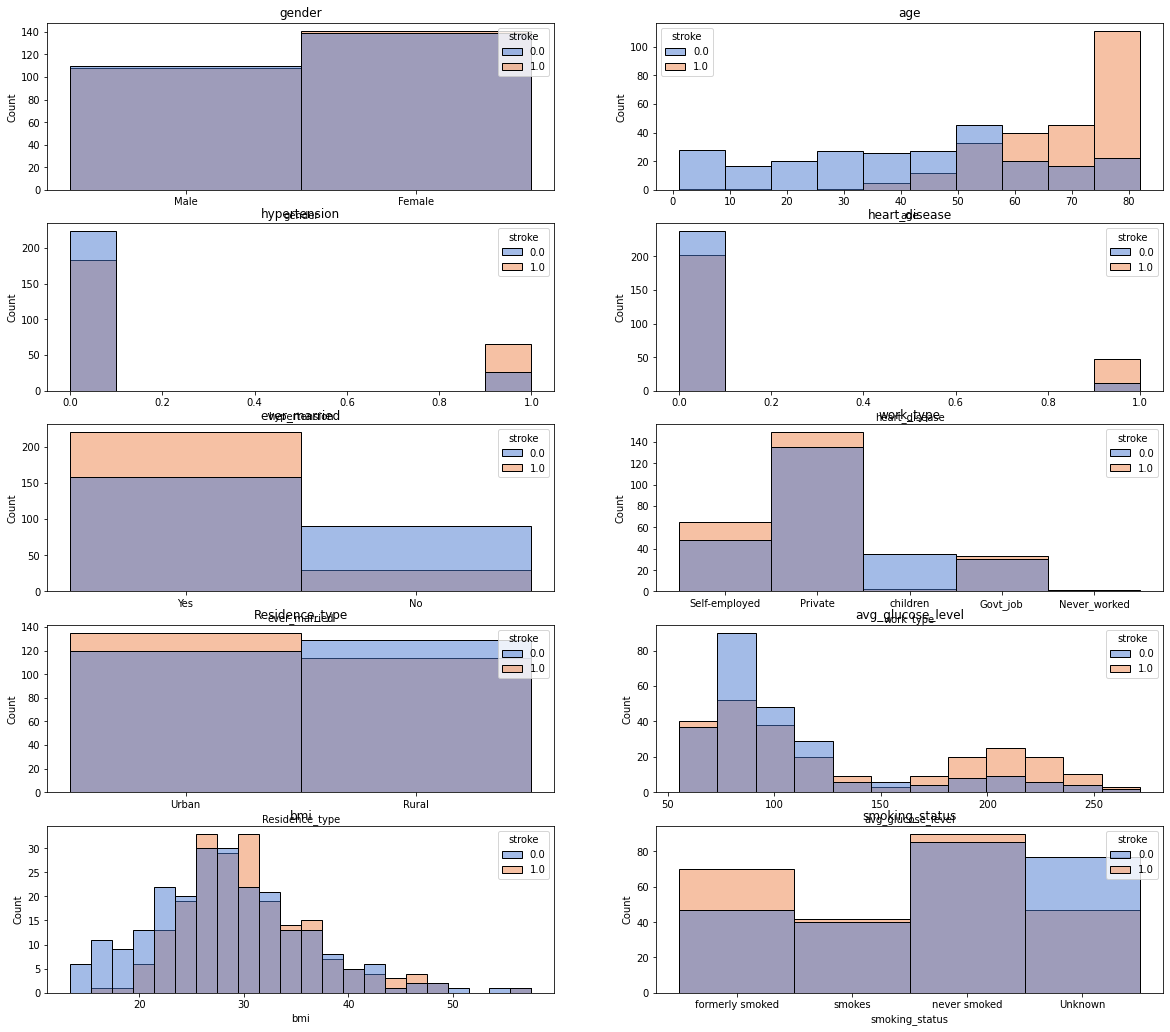

In [100]:
features = dados_undersampling.columns
lista_features = features.to_list()
lista_features.remove("id")
lista_features.remove("stroke")
i = 0
his = plt.gcf()
his.set_size_inches(20, 40)
for feature in lista_features:
    i = i+1
    plt.subplot(11,2,i)
    sns.histplot(data = dados_undersampling,x = feature, hue="stroke", palette="muted").set_title(feature)

In [101]:


dummies = pd.get_dummies(dados_undersampling["gender"], prefix="gender-")
dados_pos_dummies = dados_undersampling.join(dummies)

dummies = pd.get_dummies(dados_undersampling["smoking_status"],prefix = "smoking_status-")
dados_pos_dummies = dados_pos_dummies.join(dummies)

dummies = pd.get_dummies(dados_undersampling["Residence_type"],prefix = "Residence_type-")
dados_pos_dummies = dados_pos_dummies.join(dummies)

dummies = pd.get_dummies(dados_undersampling["work_type"],prefix = "work_type-")
dados_pos_dummies = dados_pos_dummies.join(dummies)

dummies = pd.get_dummies(dados_undersampling["ever_married"],prefix = "ever_married-")
dados_pos_dummies = dados_pos_dummies.join(dummies)

dados_pos_dummies.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,...,smoking_status-_smokes,Residence_type-_Rural,Residence_type-_Urban,work_type-_Govt_job,work_type-_Never_worked,work_type-_Private,work_type-_Self-employed,work_type-_children,ever_married-_No,ever_married-_Yes
2624,23488.0,Male,80.0,1.0,0.0,Yes,Self-employed,Urban,213.33,31.1,...,0,0,1,0,0,0,1,0,0,1
268,17986.0,Female,79.0,0.0,1.0,Yes,Self-employed,Urban,67.84,25.2,...,1,0,1,0,0,0,1,0,0,1
5024,70718.0,Male,33.0,0.0,0.0,Yes,Private,Rural,153.34,31.5,...,0,1,0,0,0,1,0,0,0,1
3655,57602.0,Male,6.0,0.0,0.0,No,children,Rural,115.40,19.2,...,0,1,0,0,0,0,0,1,1,0
2541,61252.0,Male,79.0,0.0,1.0,Yes,Private,Rural,82.27,NaN,...,0,1,0,0,0,1,0,0,0,1


In [102]:
dados_pos_dummies_dropna = dados_pos_dummies.dropna(axis=1)

In [103]:
dados_pos_dummies_dropna.count()

id                                 498
gender                             498
age                                498
hypertension                       498
heart_disease                      498
ever_married                       498
work_type                          498
Residence_type                     498
avg_glucose_level                  498
smoking_status                     498
stroke                             498
gender-_Female                     498
gender-_Male                       498
smoking_status-_Unknown            498
smoking_status-_formerly smoked    498
smoking_status-_never smoked       498
smoking_status-_smokes             498
Residence_type-_Rural              498
Residence_type-_Urban              498
work_type-_Govt_job                498
work_type-_Never_worked            498
work_type-_Private                 498
work_type-_Self-employed           498
work_type-_children                498
ever_married-_No                   498
ever_married-_Yes        

In [104]:
features = dados_pos_dummies_dropna.columns
lista_features = features.to_list()
lista_features.remove("id")
lista_features.remove("gender")
lista_features.remove("ever_married")
lista_features.remove("work_type")
lista_features.remove("Residence_type")
lista_features.remove("smoking_status")
lista_features.remove("stroke")
lista_features.remove('ever_married-_No')
lista_features.remove('Residence_type-_Urban')
lista_features.remove('gender-_Female')
lista_features

['age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'gender-_Male',
 'smoking_status-_Unknown',
 'smoking_status-_formerly smoked',
 'smoking_status-_never smoked',
 'smoking_status-_smokes',
 'Residence_type-_Rural',
 'work_type-_Govt_job',
 'work_type-_Never_worked',
 'work_type-_Private',
 'work_type-_Self-employed',
 'work_type-_children',
 'ever_married-_Yes']

Normalização os dados

In [105]:
dados_normalizados = dados_pos_dummies_dropna.copy(deep = True)

for feature in lista_features:
    dados_normalizados[feature] = normalizaMinMax(dados_normalizados[feature])

dados_normalizados.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,...,smoking_status-_smokes,Residence_type-_Rural,Residence_type-_Urban,work_type-_Govt_job,work_type-_Never_worked,work_type-_Private,work_type-_Self-employed,work_type-_children,ever_married-_No,ever_married-_Yes
2624,23488.0,Male,0.975284,1.0,0.0,Yes,Self-employed,Urban,0.730083,formerly smoked,...,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0,1.0
268,17986.0,Female,0.962926,0.0,1.0,Yes,Self-employed,Urban,0.057763,smokes,...,1.0,0.0,1,0.0,0.0,0.0,1.0,0.0,0,1.0
5024,70718.0,Male,0.394464,0.0,0.0,Yes,Private,Rural,0.452865,never smoked,...,0.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0,1.0
3655,57602.0,Male,0.060801,0.0,0.0,No,children,Rural,0.277542,Unknown,...,0.0,1.0,0,0.0,0.0,0.0,0.0,1.0,1,0.0
2541,61252.0,Male,0.962926,0.0,1.0,Yes,Private,Rural,0.124445,never smoked,...,0.0,1.0,0,0.0,0.0,1.0,0.0,0.0,0,1.0


Existem muitas instancias de teste que não são positivas para stroke, o dataset está desbalanceado, para mitigar esse vies do modelo, o balanceamento do dataset é feito através do undersampling.

Separar o conjunto de validação

In [106]:
validacao_df, modelo_df = split_validation_df(dados_normalizados,0.1)
validacao_df.head

<bound method NDFrame.head of            id  gender       age  hypertension  heart_disease ever_married  \
1305  17639.0    Male  0.530400           0.0            0.0          Yes   
110   56546.0    Male  0.962926           0.0            1.0          Yes   
4135  51823.0    Male  0.876421           0.0            0.0          Yes   
5     56669.0    Male  0.987642           0.0            0.0          Yes   
572   40448.0    Male  0.653979           0.0            0.0          Yes   
64     7356.0    Male  0.913495           0.0            0.0          Yes   
2462  27626.0  Female  0.728127           0.0            0.0           No   
3807  56712.0    Male  0.006920           0.0            0.0           No   
2021  38316.0    Male  0.666337           0.0            0.0          Yes   
169     210.0    Male  0.987642           0.0            0.0          Yes   
148   72081.0  Female  0.691053           1.0            0.0          Yes   
707   72882.0    Male  0.567474           0.0 

K-Nearest Neighbors Classifier

In [107]:
knn = KNeighborsClassifier(n_neighbors=5)

TOTAL_FOLDS = 6
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
acuracia = 0
precisao = 0
recall = 0
f1 =0

matriz_confusao = []
for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    knn.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    ypredito = knn.predict(Xteste)
    matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
    print(get_accuracy(matriz_confusao))
    acuracia = acuracia + get_accuracy(matriz_confusao)
    recall = recall+get_recall(matriz_confusao)
    precisao = precisao+get_precision(matriz_confusao)
    f1 = f1+get_f1_score(matriz_confusao)


print("Acuracia média: " + (str(acuracia/TOTAL_FOLDS)))
print("Precisão médio: " + (str(precisao/TOTAL_FOLDS)))
print("Recall médio: " + (str(recall/TOTAL_FOLDS)))
print("F1 médio: " + (str(f1/TOTAL_FOLDS)))


0.56
0.5733333333333334
0.5333333333333333
0.5333333333333333
0.6
0.6486486486486487
Acuracia média: 0.5747747747747748
Precisão médio: 0.5761581109985365
Recall médio: 0.5884979711907145
F1 médio: 0.5788903614951993


Arvores de decisão

In [108]:
from sklearn.tree import DecisionTreeClassifier

dts = DecisionTreeClassifier(min_samples_leaf = 8)

TOTAL_FOLDS = 6
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
acuracia = 0
precisao = 0
recall = 0
f1 =0

for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    dts.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    ypredito = dts.predict(Xteste)
    matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
    print(get_accuracy(matriz_confusao))
    acuracia = acuracia + get_accuracy(matriz_confusao)
    recall = recall+get_recall(matriz_confusao)
    precisao = precisao+get_precision(matriz_confusao)
    f1 = f1+get_f1_score(matriz_confusao)


print("Acuracia média: " + (str(acuracia/TOTAL_FOLDS)))
print("Precisão médio: " + (str(precisao/TOTAL_FOLDS)))
print("Recall médio: " + (str(recall/TOTAL_FOLDS)))
print("F1 médio: " + (str(f1/TOTAL_FOLDS)))

0.6933333333333334
0.7333333333333333
0.6666666666666666
0.8266666666666667
0.5733333333333334
0.6891891891891891
Acuracia média: 0.6970870870870871
Precisão médio: 0.6818741588711253
Recall médio: 0.7404590690855133
F1 médio: 0.7091182447888756


Floresta de decisão

In [109]:
rfc = RandomForestClassifier(n_estimators = 150, min_samples_split = 6, max_depth = 8)

TOTAL_FOLDS = 6
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
acuracia = 0
precisao = 0
recall = 0
f1 =0

for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    rfc.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    ypredito = rfc.predict(Xteste)
    matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
    print(get_accuracy(matriz_confusao))
    acuracia = acuracia + get_accuracy(matriz_confusao)
    recall = recall+get_recall(matriz_confusao)
    precisao = precisao+get_precision(matriz_confusao)
    f1 = f1+get_f1_score(matriz_confusao)


print("Acuracia média: " + (str(acuracia/TOTAL_FOLDS)))
print("Precisão médio: " + (str(precisao/TOTAL_FOLDS)))
print("Recall médio: " + (str(recall/TOTAL_FOLDS)))
print("F1 médio: " + (str(f1/TOTAL_FOLDS)))

0.7733333333333333
0.7333333333333333
0.7066666666666667
0.7333333333333333
0.7466666666666667
0.7297297297297297
Acuracia média: 0.7371771771771772
Precisão médio: 0.7192890989293566
Recall médio: 0.7937649539783687
F1 médio: 0.7519704533729378


Adaptive Boosting

In [110]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier()

TOTAL_FOLDS = 4
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
acuracia = 0
precisao = 0
recall = 0
f1 =0

for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    adb.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    ypredito = adb.predict(Xteste)
    matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
    print(get_accuracy(matriz_confusao))
    acuracia = acuracia + get_accuracy(matriz_confusao)
    recall = recall+get_recall(matriz_confusao)
    precisao = precisao+get_precision(matriz_confusao)
    f1 = f1+get_f1_score(matriz_confusao)


print("Acuracia média: " + (str(acuracia/TOTAL_FOLDS)))
print("Precisão médio: " + (str(precisao/TOTAL_FOLDS)))
print("Recall médio: " + (str(recall/TOTAL_FOLDS)))
print("F1 médio: " + (str(f1/TOTAL_FOLDS)))

0.6991150442477876
0.7433628318584071
0.7699115044247787
0.6727272727272727
Acuracia média: 0.7212791633145615
Precisão médio: 0.704555822235585
Recall médio: 0.7673934783385121
F1 médio: 0.7341716642175358


Rede Neural

In [114]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(warm_start=True, max_iter = 1000,hidden_layer_sizes=(40,2))

TOTAL_FOLDS = 10
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
acuracia = 0
precisao = 0
recall = 0
f1 =0

for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]
    print(treino_df.count())
    print(teste_df.count())

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    MLP.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    ypredito = MLP.predict(Xteste)
    matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
    print(get_accuracy(matriz_confusao))
    acuracia = acuracia + get_accuracy(matriz_confusao)
    recall = recall+get_recall(matriz_confusao)
    precisao = precisao+get_precision(matriz_confusao)
    f1 = f1+get_f1_score(matriz_confusao)


print("Acuracia média: " + (str(acuracia/TOTAL_FOLDS)))
print("Precisão médio: " + (str(precisao/TOTAL_FOLDS)))
print("Recall médio: " + (str(recall/TOTAL_FOLDS)))
print("F1 médio: " + (str(f1/TOTAL_FOLDS)))


id                                 404
gender                             404
age                                404
hypertension                       404
heart_disease                      404
ever_married                       404
work_type                          404
Residence_type                     404
avg_glucose_level                  404
smoking_status                     404
stroke                             404
gender-_Female                     404
gender-_Male                       404
smoking_status-_Unknown            404
smoking_status-_formerly smoked    404
smoking_status-_never smoked       404
smoking_status-_smokes             404
Residence_type-_Rural              404
Residence_type-_Urban              404
work_type-_Govt_job                404
work_type-_Never_worked            404
work_type-_Private                 404
work_type-_Self-employed           404
work_type-_children                404
ever_married-_No                   404
ever_married-_Yes        

In [112]:
from sklearn.ensemble import GradientBoostingClassifier

GDB = GradientBoostingClassifier(n_estimators = 200)

TOTAL_FOLDS = 6
fold_sets = k_fold(modelo_df, TOTAL_FOLDS)
acuracia = 0
precisao = 0
recall = 0
f1 =0

for fold_set in fold_sets:
    treino_df = fold_set["training_data"]
    teste_df = fold_set["test_data"]

    Xtreino = treino_df[lista_features]
    ytreino = treino_df["stroke"]
    GDB.fit(Xtreino,ytreino)

    Xteste = teste_df[lista_features]
    yteste = teste_df["stroke"]
    ypredito = GDB.predict(Xteste)
    matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))
    print(get_accuracy(matriz_confusao))
    acuracia = acuracia + get_accuracy(matriz_confusao)
    recall = recall+get_recall(matriz_confusao)
    precisao = precisao+get_precision(matriz_confusao)
    f1 = f1+get_f1_score(matriz_confusao)


print("Acuracia média: " + (str(acuracia/TOTAL_FOLDS)))
print("Precisão médio: " + (str(precisao/TOTAL_FOLDS)))
print("Recall médio: " + (str(recall/TOTAL_FOLDS)))
print("F1 médio: " + (str(f1/TOTAL_FOLDS)))

0.6933333333333334
0.7333333333333333
0.64
0.6933333333333334
0.6666666666666666
0.7162162162162162
Acuracia média: 0.6904804804804806
Precisão médio: 0.6891870880905969
Recall médio: 0.7219632738535178
F1 médio: 0.6943780692008276


Validação dos resultados encontrados

In [116]:
MLP = MLPClassifier(max_iter = 5000,hidden_layer_sizes=(40,2))

Xtreino = modelo_df[lista_features]
ytreino = modelo_df["stroke"]
MLP.fit(Xtreino,ytreino)

Xteste = validacao_df[lista_features]
yteste = validacao_df["stroke"]
ypredito = MLP.predict(Xteste)

matriz_confusao = get_confusion_matrix(list(ypredito),list(yteste))

print(get_accuracy(matriz_confusao))

acuracia = get_accuracy(matriz_confusao)
recall = get_recall(matriz_confusao)
precisao = get_precision(matriz_confusao)
f1 = get_f1_score(matriz_confusao)


print("Acuracia média: " + (str(acuracia)))
print("Precisão médio: " + (str(precisao)))
print("Recall médio: " + (str(recall)))
print("F1 médio: " + (str(f1)))

0.8367346938775511
Acuracia média: 0.8367346938775511
Precisão médio: 0.75
Recall médio: 0.9545454545454546
F1 médio: 0.84
